# Estimación de ICI mediante histogramas de diagramas de constelación

## Tareas
- [X] Hacerlo 2D
- [X] Con ambos utilizar un clasificador
- [ ] En caso tal, variar los bins

## Librerías

In [5]:
import sofa
import polars as pl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow.keras as ker
import json
import os

from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LogNorm

from sklearn.mixture import GaussianMixture
from sklearn.metrics import (accuracy_score, f1_score, multilabel_confusion_matrix,
                             ConfusionMatrixDisplay)
from sklearn.model_selection import cross_validate, KFold, train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import models, regularizers, Sequential, utils
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from itertools import product
from time import time

## Funciones globales

In [13]:
# Special function to read the known data structure
def read_data(folder_rx):
    data = {}

    # Read root directory
    for folder in os.listdir(folder_rx):
        # Check name consistency for subdirectories 
        if folder.endswith("spacing"):
            # Extract "pretty" part of the name
            spacing = folder[:-8]
            data[spacing] = {}
            
            # Read each data file
            for file in os.listdir(f"{folder_rx}/{folder}"):
                # Check name consistency for data files
                if file.find("consY") != -1:
                    # Extract "pretty" part of the name
                    osnr = file.split("_")[2][5:-4]
                    
                    # Initialize if not created yet
                    if data[spacing].get(osnr) == None:
                        data[spacing][osnr] = {}
                    # Set data
                    csv_file_data = pl.read_csv(f"{folder_rx}/{folder}/{file}")
                    data[spacing][osnr] = csv_file_data
    return data

def plot_constellation_diagram(X, ax):
    ax.scatter(X.real, X.imag, alpha=0.5)
    ax.set_title("Constellation diagram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")
    
def calculate_gmm(data, gm_kwargs):
    return GaussianMixture(**gm_kwargs).fit(data)
    
def calculate_1d_histogram(X, bins):
    hist_y, hist_x = np.histogram(X.real, bins=bins)
    # Remove last bin edge
    hist_x = hist_x[:-1]
    
    return hist_x, hist_y

def plot_1d_histogram(X, ax):
    ax.hist(X, bins=bins, density=True, alpha=0.5, label="Calculated histogram")
    
def plot_gmm_1d(gm, limits):
    x = np.linspace(*limits, 1000)
    
    logprob = gm.score_samples(x.reshape(-1, 1))
    responsibilities = gm.predict_proba(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    
    ax.plot(x, pdf_individual, '--', label="Adjusted histogram")

def plot_gmm_2d(gm, limits, ax):
    x = y = np.linspace(*limits)
    X, Y = np.meshgrid(x, y)
    Z = -gm.score_samples(np.array([X.ravel(), Y.ravel()]).T).reshape(X.shape)

    ax.contour(
        X, Y, Z,
        norm=LogNorm(vmin=1.0, vmax=1000.0), 
        levels=np.logspace(0, 3, 25), cmap="seismic"
    )
    
def calculate_3d_histogram(X, bins, limits, spacing, snr):
    hist, xedges, yedges = np.histogram2d(X.real, X.imag, bins=bins, range=[[*limits], [*limits]])

    # Define the extent
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # Create the meshgrid for the surface plot, excluding the last edge
    x_mesh, y_mesh = np.meshgrid(xedges[:-1], yedges[:-1])
    
    return hist, x_mesh, y_mesh
    
def plot_3d_histogram(x_mesh, y_mesh, hist, ax):
    ax.plot_surface(x_mesh, y_mesh, hist.T, cmap="seismic", rstride=1, cstride=1, edgecolor="none")
    ax.set_title("3D Histogram")
    ax.set_xlabel("I")
    ax.set_ylabel("Q")

In [14]:
def calc_once(varname, fn, args):
    """ Calculate a variable only once. """
    if varname not in globals():
        return fn(**args)
    return eval(varname)

def classificator(df, interval_lst, column_name):
    """Transforms a dataframe's column into classes"""
    array = df[column_name].to_numpy()
    indexes_lst = []
    for i, interval in enumerate(interval_lst):
        lower_limit, upper_limit = interval
        indexes_lst.append(np.intersect1d(np.where(lower_limit < array), np.where(array <= upper_limit)))
    
    classfull = df[column_name]
    for index, indexes in enumerate(indexes_lst):
        classfull[indexes] = index

    df_classfull = df.clone()
    df_classfull.replace(column_name, classfull)
    
    return df_classfull

def classifier_model(input_dim, layers_props_lst, classes_n, loss_fn):
    """ Compile a sequential model for classification purposes. """
    model = ker.Sequential()
    # Hidden layers
    for i, layer_props in enumerate(layers_props_lst):
        if i == 0:
            model.add(ker.layers.Dense(**layer_props, input_dim=input_dim))
        else:
            model.add(ker.layers.Dense(**layer_props))
    # Classifier
    model.add(ker.layers.Dense(units=classes_n, activation="softmax"))

    model.compile(loss=loss_fn, optimizer="adam")
    return model    


def classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks):
    """ Crossvalidation of a classification network. """
    # Scores dict
    scores = {}
    scores["loss"] = []
    scores["acc"] = {"train": [], "test": []}
    scores["f1"] = {"train": [], "test": []}
    scores["cm"] = {"train": [], "test": []}
    
    # K-fold crossvalidation
    kf = KFold(n_splits=n_splits, shuffle=True)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Input variables standarizer
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test_kf = sc.transform(X_test)
        
        model = classifier_model(X_train.shape[1], layer_props, classes_n, loss_fn)
        
        # Save test scalar loss
        if callbacks:
            loss = model.fit(
                X_train, y_train, epochs=5000, batch_size=64, verbose=0, callbacks=callbacks
            )
        else:
            loss = model.fit(X_train, y_train, epochs=5000, batch_size=64, verbose=0)
        print(f"Needed iterations: {len(loss.history['loss'])}")
        
        # Predict using train values
        fuzzy_predictions_train = model.predict(X_train)
        # Predict using test values
        fuzzy_predictions_test = model.predict(X_test_kf)
        
        # Assign class based on higher probability in membership vector
        predictions_train = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_train])
        predictions_test = np.array([np.argmax(fuzzy_prediction) for fuzzy_prediction in fuzzy_predictions_test])

        # Dataframe for better visualization
        train_data_train = pl.DataFrame(
            {"ICI": [y_train], "Predicted ICI": [predictions_train]}
        )
        train_data_test = pl.DataFrame(
            {"ICI": [y_test], "Predicted ICI": [predictions_test]}
        )

        # Accuracy
        acc_score_train = accuracy_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        acc_score_test = accuracy_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # F1
        f1_score_train = f1_score(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"],
            average="micro"
        )
        f1_score_test = f1_score(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"],
            average="micro"
        )
         
        # Confusion Matrix
        cm_score_train = multilabel_confusion_matrix(
            *train_data_train["ICI"], *train_data_train["Predicted ICI"]
        )
        cm_score_test = multilabel_confusion_matrix(
            *train_data_test["ICI"], *train_data_test["Predicted ICI"]
        )

        # Append to lists
        scores["loss"].append(loss)
        scores["acc"]["train"].append(acc_score_train)
        scores["acc"]["test"].append(acc_score_test)
        scores["f1"]["train"].append(f1_score_train)
        scores["f1"]["test"].append(f1_score_test)
        scores["cm"]["train"].append(cm_score_train)
        scores["cm"]["test"].append(cm_score_test)
        
    return scores


def test_classification_model(data, n_splits, max_neurons, activations, classes_n,
                               use_osnr=True, loss_fn="sparse_categorical_crossentropy"):
    """ Test a spectral overlapping classification model with given parameters. """
    # Set variable number
    var_n = 97 if use_osnr else 96
    
    # Split variables
    # Variables
    X = np.array(data[:, 0:var_n])
    # Tags
    y = np.array(data[:, -1])
    
    # Layer properties
    layer_props = [
        {"units": max_neurons // (2**i), "activation": activation}
        for i, activation in enumerate(activations)
    ]
    print(layer_props)
    callbacks = [
        EarlyStopping(monitor="loss", patience=30, mode="min", restore_best_weights=True)
    ]
    
    return classification_crossvalidation(X, y, n_splits, layer_props, classes_n, loss_fn, callbacks)

def plot_cm(scores, interval_lst):
    CM = np.array(scores.get("cm").get("test"))
    for n, interval in enumerate(interval_lst):
        result = np.zeros(CM[0][0].shape)
        for cm in CM:
            result = np.add(result, cm[n])
        result /= np.sum(result)
        disp = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=["Positive", "Negative"])
        disp.plot(colorbar=False)
        lower_limit, upper_limit = interval 
        plt.title(f"Confusion matrix for class from {lower_limit} GHz up to {upper_limit} GHz")
        plt.show()

In [15]:
def plot_loss(score, end=500):
    """ Plot loss evolution for each k-fold. """
    for k, loss in enumerate(score["loss"]):
        loss_length = len(loss.history["loss"])
        loss_values = loss.history["loss"][:end if loss_length > end else loss_length]
        epoch_values = range(end if loss_length > end else loss_length)
        plt.plot(epoch_values, loss_values, label=f"k = {k+1}")

def plot_losses(scores, scenario, cmp_fn, cmp_values=[], end=500, based_on_index=False):
    """ Plot loss graphics for each scenario. """
    # Handle default cmp_values
    if len(cmp_values) == 0:
        cmp_values = np.zeros(len(scores))
        
    fig_loss = plt.figure(figsize=(16, 3*len(scores)), layout="constrained")
    fig_loss.suptitle(f"{scenario} loss history", size="x-large")
    
    for index, (score, cmps) in enumerate(zip(scores, cmp_values)):
        plt.subplot(len(scores)//2, 2, index + 1)
        plot_loss(score, end=end)
        
        plt.title(cmp_fn(cmps) if not based_on_index else cmp_fn(index))
        
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        # Transparent white box black edge legend
        legend = plt.legend(loc="upper right", edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))
        
        plt.grid(True)

def plot_scores(scores, x_values, scenario, score_names, data_type,
                label, xlabel, markers=[], colors=[], based_on_index=False,
                log=False, multiple_points=False, plot_train=True):
    fig_scores = plt.figure(figsize=(16, 6), layout="constrained")
    fig_scores.suptitle(f"{scenario} scores")
    i = 0
    for sn in score_names:
        ax = plt.subplot(1, len(score_names), i+1)
        for dt in data_type:
            if not plot_train and dt == "train":
                continue
            points = [np.average(score[sn][dt]) for score in scores]
            if not multiple_points:
                label_value = ""
                plt.scatter(x_values, points, marker=markers[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(i)}", s=100)
            else:
                label_value = ""
                points1 = points[::2]
                points2 = points[1::2]
                plt.scatter(x_values, points1, marker=markers[0 if dt == "train" else 1],
                            color=colors[0 if dt == "train" else 1],
                            label=f"{dt.title()} {label(0)}", s=100)
                plt.scatter(x_values, points2, marker=markers[2 if dt == "train" else 3],
                            color=colors[2 if dt == "train" else 3],
                            label=f"{dt.title()} {label(1)}", s=100)
            title = ""
            if sn == "r2":
                title = "R²"
            elif sn == "acc":
                title = "Accuracy"
            else:
                title = sn.upper()
            plt.title(title)
                
        plt.xlabel(xlabel)
        # Adjust logarithmic scale if requested
        if log:
            plt.xscale("log", base=2)
            
        # Make integer xticks if matches}
        if type(x_values[0]) == np.int64:
            ax.set_xticks(x_values)
            
        if type(x_values[0]) == str:
            ax.set_xticks(range(len(x_values)), x_values)
            
        # Shrink current axis by 20%
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Transparent white box black edge legend
        legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                            edgecolor="black")
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((1, 1, 1, 0.01))

        plt.grid(True)
        i += 1
    plt.show()

## Restaurar variables

In [5]:
%store -r histograms_gmm
%store -r histograms_hist
%store -r scores_histograms_2classes_woOSNR
%store -r scores_histograms_2classes
%store -r scores_histograms_3classes_woOSNR
%store -r scores_histograms_3classes
%store -r scores_histograms_4classes_woOSNR
%store -r scores_histograms_4classes
%store -r scores_histograms_5classes_woOSNR
%store -r scores_histograms_5classes
%store -r scores_histograms_6classes_woOSNR
%store -r scores_histograms_6classes
%store -r scores_histograms_7classes_woOSNR
%store -r scores_histograms_7classes

no stored variable or alias scores_histograms_2classes_woOSNR
no stored variable or alias scores_histograms_2classes


## Leer datos

In [45]:
file_tx = "Demodulation/Data/Processed/2x16QAM_16GBd.csv"
folder_rx = "Demodulation/Data/Processed"

# Transmitted data
X_tx = np.array(pl.read_csv(file_tx))

# Read received data
data = read_data(folder_rx)

In [46]:
X_tx

array([[ 3.,  3.],
       [-3., -3.],
       [ 3., -1.],
       ...,
       [ 1.,  3.],
       [ 3., -3.],
       [ 3.,  1.]])

## Obtener histogramas

In [57]:
spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]

histograms_hist = {}
histograms_gmm = {}
bins = 128
limits = [-5, 5]

for spacing in spacings:
    X_rx = data[f"{spacing}GHz"]
    for snr in X_rx:
        # Extract data 
        X_ch = np.array(X_rx[snr])
        X_ch = X_ch[:, 0] + 1j*X_ch[:, 1]

        # Calculate 2D GMM
        input_data = np.vstack((X_ch.real, X_ch.imag)).T
        gm_kwargs = {
            "means_init": np.array(list(product([-3, -1, 1, 3], repeat=2))), 
            "n_components": 16
        }
        gm_2d = calculate_gmm(input_data, gm_kwargs)
        
        # Calculate 3D histogram
        hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits, spacing, snr)
        
        # Save 3D histogram
        if histograms_hist.get(f"{spacing}GHz") == None:
            histograms_hist[f"{spacing}GHz"] = {}
        histograms_hist[f"{spacing}GHz"][snr] = hist
    
        # Calculate I and Q histograms
        hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_i = calculate_gmm(input_data, gm_kwargs)

        # Q
        hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_q = calculate_gmm(input_data, gm_kwargs)
    
        # Save gaussians
        if histograms_gmm.get(f"{spacing}GHz") == None:
            histograms_gmm[f"{spacing}GHz"] = {}
        histograms_gmm[f"{spacing}GHz"][snr] = [gm_2d, gm_i, gm_q]
        
%store histograms_hist
%store histograms_gmm

Stored 'histograms_hist' (dict)
Stored 'histograms_gmm' (dict)


In [ ]:
spacings = ["15", "15.5", "16", "16.5", "17", "17.6", "18"]

for spacing in spacings:
    X_rx = data[f"{spacing}GHz"]
    for snr in X_rx:
        # Extract data 
        X_ch = np.array(X_rx[snr])
        X_ch = X_ch[:, 0] + 1j*X_ch[:, 1]

        plt.figure(figsize=(12, 12), layout="tight")

        # Plot constellation diagram
        ax = plt.subplot(2, 2, 1)
        plot_constellation_diagram(X_ch, ax)
        
        gm_2d = histograms_gmm.get(f"{spacing}GHz").get(snr)[0]
        
        # Plot 2D GMM
        plot_gmm_2d(gm_2d, limits, ax)
        ax.grid(True)

        # Calculate 3D histogram
        hist, x_mesh, y_mesh = calculate_3d_histogram(X_ch, bins, limits, spacing, snr)
        
        # Plot 3D histogram
        ax = plt.subplot(2, 2, 2, projection="3d")
        plot_3d_histogram(x_mesh, y_mesh, hist, ax)

        # Plot I and Q histograms separately
        # I
        ax = plt.subplot(2, 2, 3)
        plot_1d_histogram(X_ch.real, ax)
        
        hist_x, hist_y = calculate_1d_histogram(X_ch.real, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_i = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_i, limits)

        ax.set_title("I-Histogram")
        ax.set_xlabel("I")
        ax.grid(True)

        # Q
        ax = plt.subplot(2, 2, 4)
        plot_1d_histogram(X_ch.imag, ax)
        
        hist_x, hist_y = calculate_1d_histogram(X_ch.imag, bins)
        input_data = np.repeat(hist_x, hist_y).reshape(-1, 1)
        gm_kwargs = {
            "means_init": np.array([-3, -1, 1, 3]).reshape(4, 1), 
            "n_components": 4
        }
        gm_q = calculate_gmm(input_data, gm_kwargs)
        plot_gmm_1d(gm_q, limits)
        ax.set_title("Q-Histogram")
        ax.set_xlabel("Q")
        ax.grid(True)
    
        plt.suptitle(f"Plots for {snr} OSNR and {spacing}GHz of spacing")

        plt.show()

## Preparar datos

In [67]:
# Dataframe con 98 columnas
# 16 primeras para las medias
# 64 siguientes para los valores de las matrices de covarianza
# Penúltima para el valor del OSNR (dB)
# Última para el valor del espaciamiento (GHz)

df_dict = {f"col{n}": [] for n in range(98)}

# Iterate over the dictionary and populate the DataFrame
for spacing, osnr in histograms_gmm.items():
    for osnr_, gmm_data in osnr.items():
        gmm = gmm_data[0]
        means = gmm.means_.flatten()
        covariances = gmm.covariances_.flatten()
        osnr_value = np.array([float(osnr_[:-2])])
        spacing_value = np.array([float(spacing[:-3])])
        
        features = np.concatenate((means, covariances, osnr_value, spacing_value))
        
        for n in range(98):
            df_dict[f"col{n}"].append(features[n])
# Reset the index of the DataFrame
df = pl.DataFrame(df_dict)

# Print the DataFrame
print(df)
df.write_json("histograms.json")

shape: (70, 98)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬───────┬───────┐
│ col0      ┆ col1      ┆ col2      ┆ col3      ┆ … ┆ col94     ┆ col95    ┆ col96 ┆ col97 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---   ┆ ---   │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64   ┆ f64   │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪═══════╪═══════╡
│ -2.715876 ┆ -2.757723 ┆ -2.770407 ┆ -0.899518 ┆ … ┆ 0.002125  ┆ 0.27351  ┆ 23.0  ┆ 15.0  │
│ -2.70152  ┆ -2.708522 ┆ -2.748146 ┆ -0.873293 ┆ … ┆ 0.003248  ┆ 0.243064 ┆ 25.0  ┆ 15.0  │
│ -2.730963 ┆ -2.735929 ┆ -2.774846 ┆ -0.890546 ┆ … ┆ -0.000036 ┆ 0.249809 ┆ 27.0  ┆ 15.0  │
│ -2.692345 ┆ -2.704085 ┆ -2.749606 ┆ -0.851273 ┆ … ┆ -0.005625 ┆ 0.202575 ┆ 30.0  ┆ 15.0  │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …        ┆ …     ┆ …     │
│ -2.672845 ┆ -2.699972 ┆ -2.740713 ┆ -0.787432 ┆ … ┆ 

## Clasificador con 2 clases

In [68]:
interval_lst = [(0, 17.6), (17.6, 18)]
df_2classes = classificator(df, interval_lst, "col97")

In [69]:
%%time
args = {"data": df_2classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_2classes_woOSNR = calc_once("scores_histograms_2classes_woOSNR", test_classification_model, args)
%store scores_histograms_2classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Stored 'scores_histograms_2classes_woOSNR' (dict)
CPU times: user 1min 27s, sys: 3.89 s, total: 1min 31s
Wall time: 1min 8s


In [70]:
%%time
args = {"data": df_2classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_2classes = calc_once("scores_histograms_2classes", test_classification_model, args)
%store scores_histograms_2classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 26ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Stored 'scores_histograms_2classes' (dict)
CPU times: user 1min 25s, sys: 3.39 s, total: 1min 29s
Wall time: 1min 6s


## Clasificador con 3 clases

In [71]:
interval_lst = [(0, 17), (17, 17.6), (17.6, 18)]
df_3classes = classificator(df, interval_lst, "col97")

In [72]:
%%time
args = {"data": df_3classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_3classes_woOSNR = calc_once("scores_histograms_3classes_woOSNR", test_classification_model, args)
%store scores_histograms_3classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Stored 'scores_histograms_3classes_woOSNR' (dict)
CPU times: user 1min 22s, sys: 3.49 s, total: 1min 25s
Wall time: 1min 3s


In [73]:
%%time
args = {"data": df_3classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_3classes = calc_once("scores_histograms_3classes", test_classification_model, args)
%store scores_histograms_3classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_3classes' (dict)
CPU times: user 1min 24s, sys: 3.41 s, total: 1min 27s
Wall time: 1min 5s


## Clasificador con 4 clases

In [74]:
interval_lst = [(0, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_4classes = classificator(df, interval_lst, "col97")

In [75]:
%%time
args = {"data": df_4classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_4classes_woOSNR = calc_once("scores_histograms_4classes_woOSNR", test_classification_model, args)
%store scores_histograms_4classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 14ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Stored 'scores_histograms_4classes_woOSNR' (dict)
CPU times: user 1min 26s, sys: 3.58 s, total: 1min 30s
Wall time: 1min 6s


In [76]:
%%time
args = {"data": df_4classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_4classes = calc_once("scores_histograms_4classes", test_classification_model, args)
%store scores_histograms_4classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_4classes' (dict)
CPU times: user 1min 23s, sys: 3.29 s, total: 1min 27s
Wall time: 1min 4s


## Clasificador con 5 clases

In [77]:
interval_lst = [(0, 16), (16, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_5classes = classificator(df, interval_lst, "col97")

In [78]:
%%time
args = {"data": df_5classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_5classes_woOSNR = calc_once("scores_histograms_5classes_woOSNR", test_classification_model, args)
%store scores_histograms_5classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Stored 'scores_histograms_5classes_woOSNR' (dict)
CPU times: user 1min 24s, sys: 3.32 s, total: 1min 27s
Wall time: 1min 5s


In [79]:
%%time
args = {"data": df_5classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_5classes = calc_once("scores_histograms_5classes", test_classification_model, args)
%store scores_histograms_5classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 17ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_5classes' (dict)
CPU times: user 1min 26s, sys: 3.3 s, total: 1min 29s
Wall time: 1min 6s


## Clasificador con 6 clases

In [80]:
interval_lst = [(0, 15.5), (15.5, 16), (16, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_6classes = classificator(df, interval_lst, "col97")

In [81]:
%%time
args = {"data": df_6classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_6classes_woOSNR = calc_once("scores_histograms_6classes_woOSNR", test_classification_model, args)
%store scores_histograms_6classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_6classes_woOSNR' (dict)
CPU times: user 1min 28s, sys: 3.34 s, total: 1min 31s
Wall time: 1min 8s


In [82]:
%%time
args = {"data": df_6classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_6classes = calc_once("scores_histograms_6classes", test_classification_model, args)
%store scores_histograms_6classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Stored 'scores_histograms_6classes' (dict)
CPU times: user 1min 24s, sys: 3.32 s, total: 1min 27s
Wall time: 1min 5s


## Clasificador con 7 clases

In [83]:
interval_lst = [(0, 15), (15, 15.5), (15.5, 16), (16, 16.5), (16.5, 17), (17, 17.6), (17.6, 18)]
df_7classes = classificator(df, interval_lst, "col97")

In [84]:
%%time
args = {"data": df_7classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": False}
scores_histograms_7classes_woOSNR = calc_once("scores_histograms_7classes_woOSNR", test_classification_model, args)
%store scores_histograms_7classes_woOSNR

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 13ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Stored 'scores_histograms_7classes_woOSNR' (dict)
CPU times: user 1min 23s, sys: 3.34 s, total: 1min 26s
Wall time: 1min 4s


In [85]:
%%time
args = {"data": df_7classes, "n_splits": 5, "max_neurons": 256, "activations": ["relu", "tanh", "sigmoid"], "classes_n": len(interval_lst), "loss_fn": "sparse_categorical_crossentropy", "use_osnr": True}
scores_histograms_7classes = calc_once("scores_histograms_7classes", test_classification_model, args)
%store scores_histograms_7classes

[{'units': 256, 'activation': 'relu'}, {'units': 128, 'activation': 'tanh'}, {'units': 64, 'activation': 'sigmoid'}]
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 12ms/step
Needed iterations: 5000
1/1 [==============================] - 0s 11ms/step
Stored 'scores_histograms_7classes' (dict)
CPU times: user 1min 26s, sys: 3.08 s, total: 1min 29s
Wall time: 1min 7s


## Gráficas

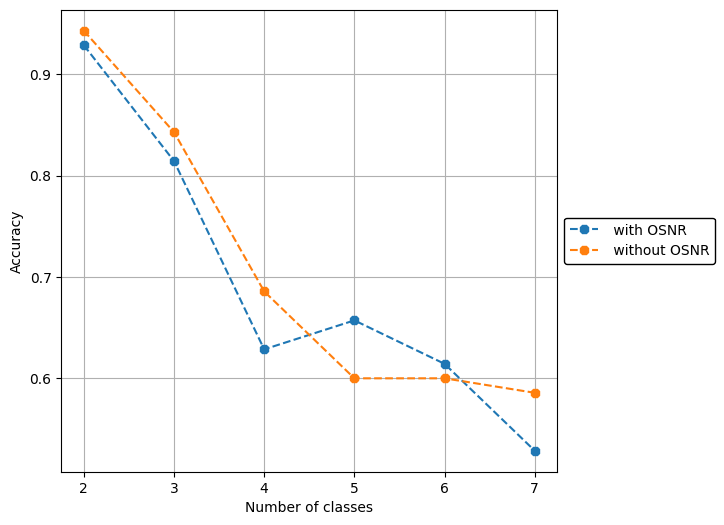

In [86]:
classes_n = [2, 3, 4, 5, 6, 7]
OSNR = ["", "_woOSNR"]
classes_scores = {f"scores_histograms{osnr}":
                  [np.average(
                      eval(f"scores_histograms_{n}classes{osnr}").get(
                          "acc"
                      ).get(
                          "test"
                      )
                  ) for n in classes_n]
                  for osnr in OSNR
                 }
plt.figure(figsize=(8, 6), layout="constrained")
ax = plt.subplot(1, 1, 1)
for osnr in OSNR:
    OSNR_label = " with OSNR" if osnr == "" else " without OSNR"
    marker = "8"
    plt.plot(classes_n, classes_scores.get(f"scores_histograms{osnr}"),
             marker=marker, linestyle="--",
             label=OSNR_label)
plt.xlabel("Number of classes")
ax.set_xticks(classes_n)
plt.ylabel("Accuracy")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Transparent white box black edge legend
legend = plt.legend(loc="center left", bbox_to_anchor=(1, 0.5),
                    edgecolor="black")
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 0.01))
plt.grid(True)

plt.savefig("hist_classes.svg", format="svg", transparent=True, bbox_inches="tight")